In [ ]:
from zipfile import ZipFile
import requests
import json

# progress bar
from tqdm import tqdm
import os, shutil, cv2
import pandas as pd

In [ ]:
# 1. buat directory
base_dir="./data/coco2017"

# struktur folder
os.makedirs(os.path.join(base_dir, "images", "train2017"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "images", "val2017"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "images", "annotations"), exist_ok=True)

print("Folder successfully created...")


Folder successfully created...


In [ ]:
urls = {
    "train_images": "http://images.cocodataset.org/zips/train2017.zip",
    "val_images": "http://images.cocodataset.org/zips/val2017.zip",
    "annotations": "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
}

download_dir = base_dir
subset_size= 50000

# download & extract
for name, url in urls.items():
  # print(name, url)
  zip_path = os.path.join(download_dir, f"{name}.zip")

  print(f"Donwload {name}...")
  response = requests.get(url, stream=True) #donwload bertahap(stream)
  with open(zip_path, 'wb') as f:
    for chunk in response.iter_content(chunk_size=1024):
      # pastikan write tdk empty
      if chunk:
        f.write(chunk)
  print(f"Download & extract {zip_path}...")

  with ZipFile(zip_path, 'r') as zip:
    if "train" in name:
      zip.extractall(os.path.join(base_dir, "images", "train2017"))
    elif "val" in name:
      zip.extractall(os.path.join(base_dir, "images", "val2017"))
    else:
      zip.extractall(os.path.join(base_dir, "annotations"))
  print(f"Extracted {name}")

print("process donwload & extract done.")

Donwload train_images...
Download & extract ./data/coco2017/train_images.zip...
Extracted train_images
Donwload val_images...
Download & extract ./data/coco2017/val_images.zip...
Extracted val_images
Donwload annotations...
Download & extract ./data/coco2017/annotations.zip...
Extracted annotations
process donwload & extract done.


In [ ]:
# subset (JSON)
annotation_path = os.path.join(base_dir, "annotations", "annotations","captions_train2017.json")
subset_path = os.path.join(base_dir, "annotations", "annotations","captions_train2017_subset.json")
subset_size=50000

if not os.path.exists(annotation_path):
  print(f"Error annot file not found = {annotation_path}")
else:
  with open(annotation_path, "r") as f:
    data=json.load(f)
  print(f"total annot asli : {len(data['annotations'])}")

  # subset
  subset_annot = data['annotations'][:subset_size]

  # ambil id gbr
  img_ids = set(ann["image_id"] for ann in subset_annot)
  subset_img_info = [img for img in data["images"] if img["id"] in img_ids]

  # simpan subset
  subset_data = {
      "info": data.get("info", {}),
      "licenses": data.get("licenses", []),
      "images": subset_img_info, # info image di subset
      "annotations": subset_annot
  }

  os.makedirs(os.path.dirname(subset_path), exist_ok=True)
  with open(subset_path, "w") as f:
      json.dump(subset_data, f)

  print(f"Subset JSON dibuat: {subset_path}")
  print(f"tot img di subset info: {len(subset_img_info)} | Tot caption: {len(subset_annot)}")

  # copy ke local source
  src_dir_option = os.path.join(base_dir, "images", "train2017", "train2017")

  src_dir = None
  if os.path.exists(src_dir_option) and len(os.listdir(src_dir_option)) > 0:
      src_dir = src_dir_option


  if src_dir:
      # destination directory
      dst_dir = os.path.join(base_dir, "images", "train2017_subset")
      os.makedirs(dst_dir, exist_ok=True)

      print(f"\nCopying subset image files from {src_dir} to {dst_dir}...")
      # Copy only file names present in the subset_images_info
      copied_count = 0
      # Create a set of file names to copy for faster lookup
      subset_image_filenames = {img_info["file_name"] for img_info in subset_img_info}

      # Iterate through files in the source directory and copy if they are in the subset
      for filename in tqdm(os.listdir(src_dir), desc="Checking & copying images"):
          if filename in subset_image_filenames:
                src_path = os.path.join(src_dir, filename)
                dst_path = os.path.join(dst_dir, filename)
                try:
                    shutil.copy(src_path, dst_path)
                    copied_count += 1
                except Exception as e:
                    print(f"Warning: Could not copy file {src_path} to {dst_path}: {e}")


      print(f"Finished copying. {copied_count} images copied to subset folder.")
      # Check if the number of copied files matches the number of images in the subset info
      if copied_count != len(subset_img_info):
          print(f"Warning: Number of copied files ({copied_count}) != subset info ({len(subset_img_info)}). Some source files might be missing.")

      print("Subset 50K image & caption (locally copied images) ready")


total annot asli : 591753
Subset JSON dibuat: ./data/coco2017/annotations/annotations/captions_train2017_subset.json
tot img di subset info: 10102 | Tot caption: 50000

Copying subset image files from ./data/coco2017/images/train2017/train2017 to ./data/coco2017/images/train2017_subset...


Checking & copying images: 100%|██████████| 118287/118287 [00:34<00:00, 3431.40it/s]

Finished copying. 10102 images copied to subset folder.
Subset 50K image & caption (locally copied images) ready


In [ ]:
json_path = "./data/coco2017/annotations/annotations/captions_train2017_subset.json"

with open(json_path, "r") as f:
  data=json.load(f)

print(data["annotations"][0].keys())

images_df = pd.DataFrame(data['images'])
annotations_df = pd.DataFrame(data['annotations'])

# gabungkan berdasarkan image_id
merged_df = annotations_df.merge(images_df, left_on='image_id', right_on='id', suffixes=('_caption', '_image'))

# tampilkan kolom penting
df = merged_df[['image_id', 'file_name', 'caption']]
print(df.head())



dict_keys(['image_id', 'id', 'caption'])
   image_id         file_name  \
0    203564  000000203564.jpg   
1    322141  000000322141.jpg   
2     16977  000000016977.jpg   
3    106140  000000106140.jpg   
4    106140  000000106140.jpg   

                                             caption  
0  A bicycle replica with a clock as the front wh...  
1  A room with blue walls and a white sink and door.  
2  A car that seems to be parked illegally behind...  
3  A large passenger airplane flying through the ...  
4  There is a GOL plane taking off in a partly cl...  


### Load coco pairs format

In [ ]:
import pandas as pd
pd.DataFrame(data["annotations"]).head()


,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


In [ ]:
def load_coco_pairs(img_dir, ann_path):
  with open(ann_path, 'r') as f:
    ann=json.load(f)

  images ={img['id']: img['file_name'] for img in ann['images']}
  pairs=[]

  annots = ann['annotations']

  for item in annots:
    img_id = item['image_id']
    img_path = os.path.join(img_dir, images[img_id])
    caption = item['caption']

    if os.path.exists(img_path):
      pairs.append((img_path, caption))

  return pairs




In [ ]:
base_dir="./data/coco2017"

train_img_dir = os.path.join(base_dir, "images", "train2017_subset")
train_ann_path = os.path.join(base_dir, "annotations", "annotations", "captions_train2017_subset.json")


In [ ]:
# load all validation data
val_img_dir = os.path.join(base_dir, "images", "val2017", "val2017")
val_ann_path = os.path.join(base_dir, "annotations", "annotations", "captions_val2017.json")

In [ ]:
# 1. load coco pairs
train_pairs = load_coco_pairs(train_img_dir, train_ann_path)
val_pairs = load_coco_pairs(val_img_dir, val_ann_path)

print("tot data loaded dr local= ", len(train_pairs))
if len(train_pairs)>0:
  print("cth: ", train_pairs[:2])


print("tot validation loaded dr local= ", len(val_pairs))
if len(val_pairs)>0:
  print("cth: ", val_pairs[:2])

tot data loaded dr local=  50000
cth:  [('./data/coco2017/images/train2017_subset/000000203564.jpg', 'A bicycle replica with a clock as the front wheel.'), ('./data/coco2017/images/train2017_subset/000000322141.jpg', 'A room with blue walls and a white sink and door.')]
tot validation loaded dr local=  25014
cth:  [('./data/coco2017/images/val2017/val2017/000000179765.jpg', 'A black Honda motorcycle parked in front of a garage.'), ('./data/coco2017/images/val2017/val2017/000000179765.jpg', 'A Honda motorcycle parked in a grass driveway')]


sample img path & caption
example 1:
img path: ./data/coco2017/images/train2017_subset/000000203564.jpg


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
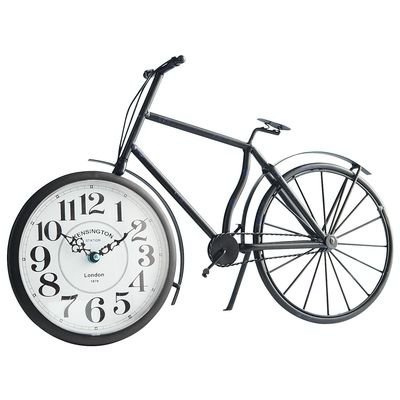

caption: A bicycle replica with a clock as the front wheel.
--------------------
example 2:
img path: ./data/coco2017/images/train2017_subset/000000322141.jpg


array([[[106,  97,  93],
        [114, 105,  96],
        [108,  98,  88],
        ...,
        [101, 101,  89],
        [103, 102,  88],
        [109, 100,  90]],

       [[ 99,  98,  84],
        [106, 102,  83],
        [107, 100,  81],
        ...,
        [100, 100,  88],
        [101, 101,  87],
        [104,  98,  87]],

       [[101, 100,  86],
        [103, 101,  77],
        [107, 103,  79],
        ...,
        [ 99,  97,  96],
        [101,  97,  96],
        [104,  96,  96]],

       ...,

       [[ 84,  84,  72],
        [ 84,  81,  73],
        [ 86,  78,  79],
        ...,
        [ 96,  80,  73],
        [ 96,  81,  72],
        [ 94,  84,  67]],

       [[ 88,  80,  73],
        [ 86,  81,  72],
        [ 85,  81,  76],
        ...,
        [ 99,  81,  74],
        [ 99,  80,  72],
        [ 99,  82,  63]],

       [[ 88,  76,  70],
        [ 85,  80,  65],
        [ 83,  85,  63],
        ...,
        [ 92,  80,  68],
        [ 87,  81,  70],
        [ 85,  84,  64]]], dtype=uint8)
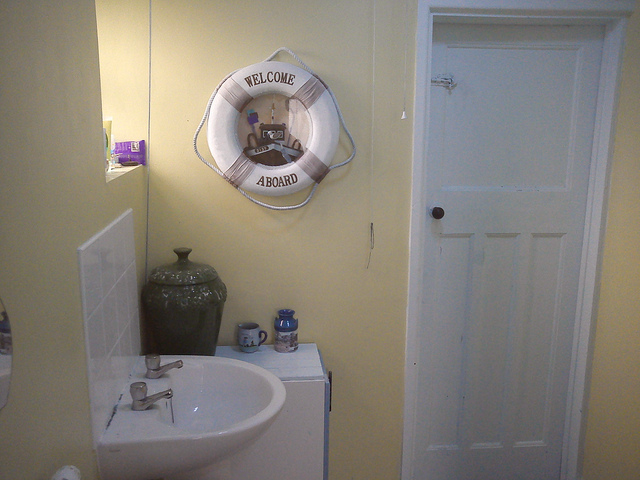

caption: A room with blue walls and a white sink and door.
--------------------
example 3:
img path: ./data/coco2017/images/train2017_subset/000000016977.jpg


array([[[ 30,  69,  61],
        [  1,  48,  39],
        [ 22,  63,  55],
        ...,
        [136, 172, 155],
        [201, 220, 205],
        [ 85, 140, 115]],

       [[ 39,  81,  70],
        [ 30,  61,  54],
        [ 23,  49,  43],
        ...,
        [181, 199, 182],
        [171, 204, 189],
        [ 85, 165, 148]],

       [[ 28,  84,  71],
        [ 32,  85,  72],
        [ 17,  62,  53],
        ...,
        [212, 220, 197],
        [122, 169, 137],
        [128, 152, 128]],

       ...,

       [[136, 155, 160],
        [142, 158, 165],
        [147, 164, 173],
        ...,
        [145, 150, 159],
        [149, 151, 161],
        [150, 153, 161]],

       [[162, 179, 182],
        [160, 174, 180],
        [154, 169, 178],
        ...,
        [166, 170, 175],
        [154, 155, 165],
        [149, 149, 163]],

       [[163, 178, 187],
        [152, 169, 182],
        [158, 174, 190],
        ...,
        [134, 138, 139],
        [154, 156, 156],
        [165, 165, 165]]], dtype=uint8)
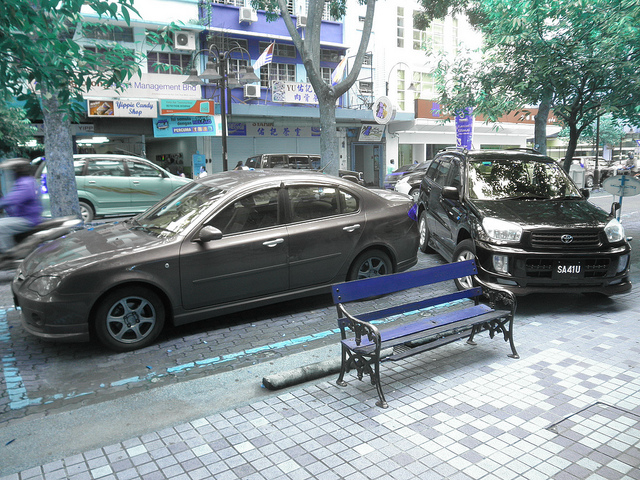

caption: A car that seems to be parked illegally behind a legally parked car
--------------------
example 4:
img path: ./data/coco2017/images/train2017_subset/000000106140.jpg


array([[[146, 142, 147],
        [148, 143, 145],
        [147, 140, 143],
        ...,
        [118, 109, 106],
        [113, 104, 107],
        [111, 103, 113]],

       [[153, 144, 147],
        [153, 144, 147],
        [151, 143, 144],
        ...,
        [117, 106, 108],
        [114, 104, 104],
        [118, 107, 110]],

       [[156, 141, 145],
        [156, 143, 145],
        [154, 144, 144],
        ...,
        [117, 104, 112],
        [117, 104, 106],
        [120, 104, 105]],

       ...,

       [[ 43,  34,  25],
        [ 47,  34,  26],
        [ 52,  37,  28],
        ...,
        [ 49,  39,  39],
        [ 46,  33,  41],
        [ 48,  43,  40]],

       [[ 45,  33,  29],
        [ 45,  38,  29],
        [ 45,  36,  23],
        ...,
        [ 55,  39,  40],
        [ 55,  34,  32],
        [ 49,  39,  21]],

       [[ 39,  40,  38],
        [ 31,  41,  35],
        [ 35,  41,  40],
        ...,
        [ 72,  50,  45],
        [ 81,  56,  46],
        [ 62,  48,  49]]], dtype=uint8)
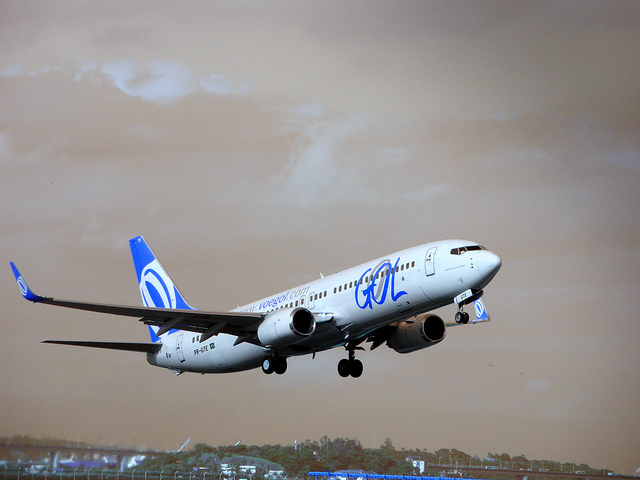

caption: A large passenger airplane flying through the air.
--------------------
example 5:
img path: ./data/coco2017/images/train2017_subset/000000106140.jpg


array([[[146, 142, 147],
        [148, 143, 145],
        [147, 140, 143],
        ...,
        [118, 109, 106],
        [113, 104, 107],
        [111, 103, 113]],

       [[153, 144, 147],
        [153, 144, 147],
        [151, 143, 144],
        ...,
        [117, 106, 108],
        [114, 104, 104],
        [118, 107, 110]],

       [[156, 141, 145],
        [156, 143, 145],
        [154, 144, 144],
        ...,
        [117, 104, 112],
        [117, 104, 106],
        [120, 104, 105]],

       ...,

       [[ 43,  34,  25],
        [ 47,  34,  26],
        [ 52,  37,  28],
        ...,
        [ 49,  39,  39],
        [ 46,  33,  41],
        [ 48,  43,  40]],

       [[ 45,  33,  29],
        [ 45,  38,  29],
        [ 45,  36,  23],
        ...,
        [ 55,  39,  40],
        [ 55,  34,  32],
        [ 49,  39,  21]],

       [[ 39,  40,  38],
        [ 31,  41,  35],
        [ 35,  41,  40],
        ...,
        [ 72,  50,  45],
        [ 81,  56,  46],
        [ 62,  48,  49]]], dtype=uint8)
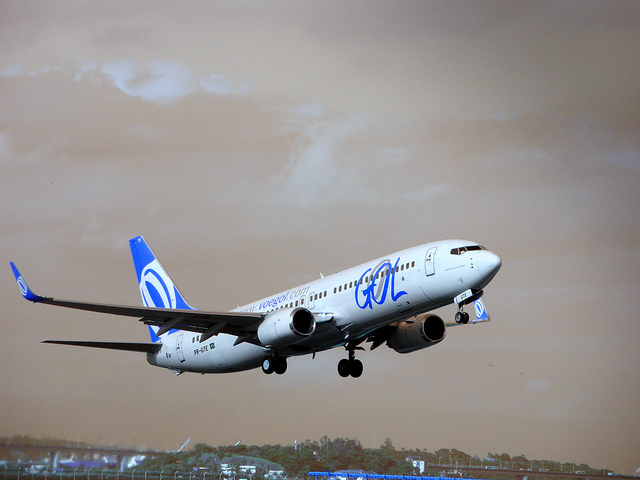

caption: There is a GOL plane taking off in a partly cloudy sky.
--------------------


In [ ]:
if 'train_pairs' in locals() and train_pairs:
  print("sample img path & caption")
  for i, (img_path, capt) in enumerate(train_pairs[:5]):
    print(f"example {i+1}:")
    print(f"img path: {img_path}")
    display(cv2.imread(img_path))

    print(f"caption: {capt}")
    print("-"*20)
else:
  print("pairs not loaded")
